In [1]:
TRANSACTIONS_FILE = "data/day_point_dataset_v5.csv"
APP_TO_CLASS_FILE = "data/app_mappings_2st_round.csv"

import pandas as pd

In [2]:
import numpy as np


In [3]:
df_day_point = pd.read_csv(TRANSACTIONS_FILE, sep=";", index_col=0)
df_app_to_class = pd.read_csv(APP_TO_CLASS_FILE)

df_day_point.head()


,employeeId,app,app_durations,app_start_times,app_end_times,start_time,end_time,hours_until_next_workday,workday_duration
0,w--4rnszliaxy12_1,"['Workpuls', 'Windows_Explorer', 'Private_Link...","[0.09476666666666667, 0.029849999999999998, 0....","[Timestamp('2024-09-02 09:23:12.586000'), Time...","[Timestamp('2024-09-02 09:23:18.272000'), Time...",2024-09-02 09:23:12.586,2024-09-02 20:01:35.212,255.667794,638.377100
1,w--4rnszliaxy12_10,"['Workpuls', 'discord.com', 'docs.google.com',...","[0.07228333333333332, 0.27903333333333336, 0.1...","[Timestamp('2024-09-13 11:41:39.272000'), Time...","[Timestamp('2024-09-13 11:41:43.609000'), Time...",2024-09-13 11:41:39.272,2024-09-13 20:03:15.818,15.699346,501.609100
2,w--4rnszliaxy12_11,"['Workpuls', 'Private_Links', 'docs.google.com...","[0.11863333333333334, 0.15068333333333334, 0.0...","[Timestamp('2024-09-14 11:45:13.464000'), Time...","[Timestamp('2024-09-14 11:45:20.582000'), Time...",2024-09-14 11:45:13.464,2024-09-14 20:01:58.878,15.652016,496.756900
3,w--4rnszliaxy12_12,"['Workpuls', 'discord.com', 'docs.google.com',...","[0.06655, 0.26875, 0.06731666666666666, 0.7145...","[Timestamp('2024-09-15 11:41:06.134000'), Time...","[Timestamp('2024-09-15 11:41:10.127000'), Time...",2024-09-15 11:41:06.134,2024-09-15 20:01:12.075,13.594557,500.099017
4,w--4rnszliaxy12_13,"['Workpuls', 'Private_Links', 'discord.com', '...","[0.08503333333333334, 0.12776666666666667, 0.9...","[Timestamp('2024-09-16 09:36:52.481000'), Time...","[Timestamp('2024-09-16 09:36:57.583000'), Time...",2024-09-16 09:36:52.481,2024-09-16 20:15:06.288,15.811850,638.230117


In [4]:
from pandas import Timestamp

def process_row(row):
    apps = eval(row['app'])
    durations = eval(row['app_durations'])
    start_times = eval(row['app_start_times'])
    end_times = eval(row['app_end_times'])
    
    return pd.DataFrame({
        'app': apps,
        'duration': durations,
        'app_start_time': start_times,
        'app_end_time': end_times,
        'employeeId': [row['employeeId']] * len(apps),
        'workday_start': [row['start_time']] * len(apps),
        'workday_end': [row['end_time']] * len(apps),
        'workday_duration': [row['workday_duration']] * len(apps),
        'hours_until_next_workday': [row['hours_until_next_workday']] * len(apps)
    })

# Create exploded dataframe
exploded_df = pd.concat([process_row(row) for _, row in df_day_point.iterrows()], ignore_index=True)

# Convert duration to minutes
exploded_df['duration'] = exploded_df['duration'] * 60  # Convert to seconds

# Start from exploded df

In [1]:
import pandas as pd
exploded_df = pd.read_csv("data/applications_exploded.csv")


In [2]:
exploded_df.head(2)

,app,duration,app_start_time,app_end_time,employeeId,workday_start,workday_end,workday_duration,hours_until_next_workday
0,Workpuls,5.686,2024-09-02 09:23:12.586,2024-09-02 09:23:18.272,w--4rnszliaxy12_1,2024-09-02 09:23:12.586,2024-09-02 20:01:35.212,638.3771,255.667794
1,Windows_Explorer,1.791,2024-09-02 09:23:18.272,2024-09-02 09:23:20.063,w--4rnszliaxy12_1,2024-09-02 09:23:12.586,2024-09-02 20:01:35.212,638.3771,255.667794


In [3]:
exploded_df.workday_start.nunique()


5178

# Create sequences

In [11]:
from tqdm import tqdm
import numpy as np

def create_sequences(exploded_df, window_size=64, stride=8):
    """Create sequences using sliding window approach.
    
    Args:
        exploded_df: DataFrame with app usage data
        window_size: Maximum sequence length
        stride: Number of steps to slide the window
    """
    # Sort by employeeId and app_start_time to ensure correct order
    df_sorted = exploded_df.sort_values(['employeeId', 'app_start_time'])
    
    sequences = []
    
    # Group by employeeId and workday_start
    for (emp_id,), group in tqdm(df_sorted.groupby(['employeeId']), desc="Creating sequences"):
        # Convert timestamps to minutes since workday start
        workday_start_time = pd.to_datetime(group['workday_start'].iloc[0])
        delta_from_workday_start = np.log2(np.maximum(1, ((pd.to_datetime(group['app_start_time']) - workday_start_time)
                              .dt.total_seconds()))).tolist()
        
        apps = group['app'].tolist()
        durations = np.log2(np.maximum(1, (pd.to_datetime(group['app_end_time']) - pd.to_datetime(group['app_start_time'])).dt.total_seconds())).tolist()
        
        # Create sliding windows
        for start_idx in range(0, len(apps), stride):  # Use stride here
            end_idx = start_idx + window_size
            
            # Extract window
            window_apps = apps[start_idx:end_idx]
            window_durations = durations[start_idx:end_idx]
            # window_times = times[start_idx:end_idx]
            
            # Only keep windows that have enough data (e.g., at least 4 apps)
            if len(window_apps) >= 4:
                sequence = {
                    'apps': window_apps,
                    'durations': window_durations,
                    'employeeId': emp_id,
                    'window_start_idx': start_idx
                }
                sequences.append(sequence)
    
    return sequences

# Create sequences
sequences = create_sequences(exploded_df)


NameError: name 'exploded_df' is not defined

In [5]:
print(f"Total number of sequences: {len(sequences)}")
print("\nExample sequence:")
print(f"Number of apps: {len(sequences[0]['apps'])}")
print(f"First few apps: {sequences[0]['apps'][:5]}")
print(f"First few durations (log_2(duration)): {[round(d, 2) for d in sequences[0]['durations'][:5]]}")
# print(f"First few minutes since workday start: {sequences[0]['minutes_since_workday_start'][:5]}")

Total number of sequences: 495955

Example sequence:
Number of apps: 64
First few apps: ['Workpuls', 'Windows_Explorer', 'Private_Links', 'docs.google.com', 'Private_Links']
First few durations (log_2(duration)): [2.51, 0.84, 2.69, 0.29, 2.34]


In [3]:
def create_vocab(sequences):
    """Create vocabulary mapping from sequences.
    
    Args:
        sequences: List of dictionaries containing 'apps' key
    
    Returns:
        Dictionary mapping apps to indices
    """
    # Get unique apps across all sequences
    unique_apps = set()
    for seq in sequences:
        unique_apps.update(seq['apps'])
    
    # Create mapping dictionary with special tokens
    app_to_idx = {
        '<PAD>': 0,
        '<UNK>': 1,
    }

In [6]:

    
    # Add apps to vocabulary
    for idx, app in enumerate(sorted(unique_apps)):
        app_to_idx[app] = idx + 2  # +2 because we have two special tokens
    
    print(f"Vocabulary size (including special tokens): {len(app_to_idx)}")
    return app_to_idx

app_to_idx = create_vocab(sequences)

Vocabulary size (including special tokens): 634


In [7]:
# Create directory if it doesn't exist
import os
os.makedirs('data/sequences', exist_ok=True)

# Save sequences as pickle file
import pickle
with open('data/sequences/sequences.pkl', 'wb') as f:
    pickle.dump(sequences, f)

# Save app_to_idx mapping
with open('data/sequences/app_to_idx.pkl', 'wb') as f:
    pickle.dump(app_to_idx, f)


print("Saved:")
print(f"- {len(sequences)} sequences")
print(f"- {len(app_to_idx)} unique apps in vocabulary")


Saved:
- 495955 sequences
- 634 unique apps in vocabulary


## Load sequences 64, stride 8

In [1]:
import numpy as np
import pandas as pd

In [2]:
import pickle
with open('data/sequences/sequences.pkl', 'rb') as f:
    sequences = pickle.load(f)

with open('data/sequences/app_to_idx.pkl', 'rb') as f:
    app_to_idx = pickle.load(f)

In [3]:
df_sequences = pd.DataFrame(sequences)


Total sequences: 495955
Sequences with at least one occurrence: 330526
Maximum occurrences in a single sequence: 63
Average occurrences per sequence: 3.38
Median occurrences per sequence: 2.00


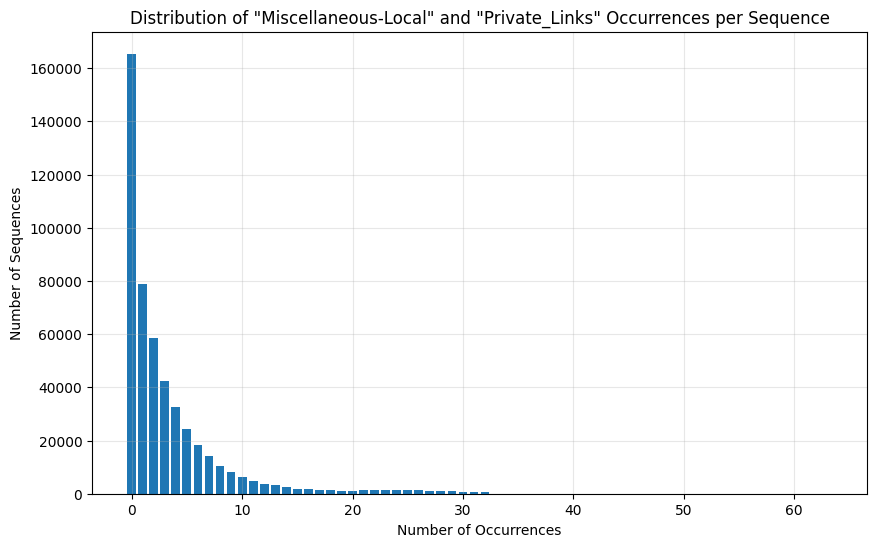

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# Count occurrences in each sequence
sequence_counts = []
for seq in sequences:
    count = sum(1 for app in seq['apps'] if app in ["Miscellaneous-Local", "Private_Links"])
    sequence_counts.append(count)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(sequence_counts, bins=range(max(sequence_counts) + 2), align='left', rwidth=0.8)
plt.title('Distribution of "Miscellaneous-Local" and "Private_Links" Occurrences per Sequence')
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Sequences')
plt.grid(True, alpha=0.3)

# Add some statistics
print(f"Total sequences: {len(sequences)}")
print(f"Sequences with at least one occurrence: {sum(1 for x in sequence_counts if x > 0)}")
print(f"Maximum occurrences in a single sequence: {max(sequence_counts)}")
print(f"Average occurrences per sequence: {np.mean(sequence_counts):.2f}")
print(f"Median occurrences per sequence: {np.median(sequence_counts):.2f}")

plt.show()

# Only tokens

In [5]:
import torch
from torch import nn
from transformers import BertConfig, BertModel
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import torch
from torch import nn
import random
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm

c:\Users\Nemanja\Documents\GitHub\focus-time\.venv\Lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [11]:
from torch import nn
import math
import os
import pickle
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import math

class ShallowTransformer_with_attn(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, seq_length=64):
        super().__init__()
        
        self.nhead = nhead  # Store number of heads as class attribute
        
        # App embeddings
        self.app_embeddings = nn.Embedding(vocab_size, d_model)
        
        # Positional embeddings
        self.pos_embeddings = nn.Parameter(torch.randn(1, seq_length, d_model))
        
        # Create transformer layers with attention capture
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=128,
                dropout=0.1,
                batch_first=True
            ) for _ in range(3)
        ])
        
        # Prediction head
        self.app_predictor = nn.Linear(d_model, vocab_size)
        
    def forward(self, app_ids, attention_mask, output_attentions=False):
        # Get app embeddings
        x = self.app_embeddings(app_ids)  # [batch_size, seq_len, d_model]
        
        # Add positional embeddings
        x = x + self.pos_embeddings[:, :x.size(1), :]
        
        # Create attention mask for transformer
        attention_mask = attention_mask == 0
        
        attention_weights = []
        
        # Pass through transformer layers
        for layer in self.encoder_layers:
            if output_attentions:
                # Multi-head attention computation
                batch_size, seq_len, d_model = x.shape
                num_heads = self.nhead  # Use stored number of heads
                head_dim = d_model // num_heads
                
                # Reshape input for attention computation
                q = x.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
                k = x.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
                
                # Compute attention scores
                scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dim)
                
                # Reshape attention mask
                if attention_mask is not None:
                    # Expand mask for multiple heads
                    expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
                    expanded_mask = expanded_mask.expand(batch_size, num_heads, seq_len, seq_len)
                    scores = scores.masked_fill(expanded_mask, float('-inf'))
                
                # Apply softmax
                attn_weights = torch.softmax(scores, dim=-1)
                attention_weights.append(attn_weights)
            
            # Forward pass through layer
            x = layer(x, src_key_padding_mask=attention_mask)
        
        # Get logits
        logits = self.app_predictor(x)
        
        if output_attentions:
            return logits, attention_weights
        return logits

class AppSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, app_to_idx, sequence_length=64, mask_prob=0.15):
        self.sequences = sequences
        self.app_to_idx = app_to_idx
        self.sequence_length = sequence_length
        self.mask_prob = mask_prob
        self.mask_token = len(app_to_idx)  # Add MASK token at end of vocabulary
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        # Convert apps to indices
        app_ids = [self.app_to_idx.get(app, self.app_to_idx['<UNK>']) 
                  for app in seq['apps']][:self.sequence_length]
        
        # Create masked version for input
        masked_app_ids = app_ids.copy()
        labels = [-100] * len(app_ids)  # -100 will be ignored by loss function
        
        # Randomly mask tokens
        for i in range(len(app_ids)):
            if random.random() < self.mask_prob:
                labels[i] = app_ids[i]  # Save original app as label
                masked_app_ids[i] = self.mask_token  # Replace with MASK token
        
        # Pad sequences if needed (should be rare with sequence_length=64)
        if len(app_ids) < self.sequence_length:
            padding_length = self.sequence_length - len(app_ids)
            masked_app_ids = masked_app_ids + [self.app_to_idx['<PAD>']] * padding_length
            labels = labels + [-100] * padding_length
            
        return {
            'app_ids': torch.tensor(masked_app_ids),
            'attention_mask': torch.tensor([1] * len(app_ids) + [0] * (self.sequence_length - len(app_ids))),
            'labels': torch.tensor(labels)
        }



# 1. Prefetch data to GPU
class PreloadedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, device):
        self.data = []
        for i in tqdm(range(len(original_dataset))):
            batch = original_dataset[i]
            self.data.append({
                k: v.to(device) for k, v in batch.items()
            })
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
df_sequences

,apps,durations,employeeId,window_start_idx
0,"[Workpuls, Windows_Explorer, Private_Links, do...","[2.5074140990154405, 0.8407653373238742, 2.691...",w--4rnszliaxy12_1,0
1,"[docs.google.com, Workpuls, Windows_Explorer, ...","[2.596219578989465, 1.5969351423872322, 2.6076...",w--4rnszliaxy12_1,8
2,"[Workpuls, Marketing_&_Advertising-Local, Conc...","[3.829443681366591, 0.0, 7.607012145915672, 3....",w--4rnszliaxy12_1,16
3,"[Miscellaneous-Local, Pause, Miscellaneous-Loc...","[6.75425952600206, 6.403761944815305, 1.019346...",w--4rnszliaxy12_1,24
4,"[Miscellaneous-Local, Pause, Miscellaneous-Loc...","[1.606915941825205, 6.0111377831889925, 4.7669...",w--4rnszliaxy12_1,32
...,...,...,...,...
495950,"[statics.teams.cdn.office.net, newpace.paceset...","[0.0, 4.2587450347408975, 3.471317544246312, 1...",w1rgkwz_w-eoxs0_9,56
495951,"[mail.google.com, Miscellaneous, mail.google.c...","[0.0, 1.016496319896196, 10.558591951389891, 6...",w1rgkwz_w-eoxs0_9,64
495952,"[Miscellaneous, Insurance, Human_Resources, Ma...","[0.014355292977070054, 0.005759269288684953, 0...",w1rgkwz_w-eoxs0_9,72
495953,"[outlook.office.com, newpace.pacesetterclaims....","[2.816599706534912, 2.3285492750097423, 0.0229...",w1rgkwz_w-eoxs0_9,80


In [8]:
dataset = AppSequenceDataset(sequences, app_to_idx, sequence_length=64)

train_emp_ids, val_emp_ids = train_test_split(
    df_sequences['employeeId'].unique(), 
    test_size=0.2, 
    random_state=42
)

train_idx = df_sequences.merge(pd.Series(train_emp_ids, name='employeeId'), on='employeeId', how='inner').index.tolist()
val_idx = df_sequences.merge(pd.Series(val_emp_ids, name='employeeId'), on='employeeId', how='inner').index.tolist()

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)


In [9]:
train_dataset = PreloadedDataset(train_dataset, device)
val_dataset = PreloadedDataset(val_dataset, device)

100%|██████████| 103341/103341 [00:32<00:00, 3132.42it/s]


In [12]:
model = ShallowTransformer_with_attn(vocab_size=len(app_to_idx) + 1, seq_length=64)  # +1 for MASK token

# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Split data
# train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)


# Create dataloaders with larger batch size since sequences are fixed length
train_loader = DataLoader(train_dataset, 
                         batch_size=256,  # Increased batch size
                         shuffle=True,
                         num_workers=0,
                         pin_memory=False)
val_loader = DataLoader(val_dataset, 
                       batch_size=256,
                       num_workers=0,
                       pin_memory=False)


In [14]:
def train_epoch(model, loader, optimizer, criterion):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc='Training'):
        # Move batch to device
        app_ids = batch['app_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(app_ids, attention_mask)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    """Evaluate model on validation set."""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            app_ids = batch['app_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(app_ids, attention_mask)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            
            # Calculate accuracy only for masked positions
            predictions = outputs.argmax(dim=-1)
            mask = labels != -100
            correct_predictions += (predictions[mask] == labels[mask]).sum().item()
            total_predictions += mask.sum().item()
            
            total_loss += loss.item()
    
    return total_loss / len(loader), correct_predictions / total_predictions

# Training loop with validation
print("Starting training...")
n_epochs = 60
train_losses = []
val_losses = []
accuracies = []

for epoch in tqdm(range(n_epochs), desc="Epochs"):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    
    # Train with progress bar for batches
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training batches'):
        # Move batch to device
        app_ids = batch['app_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(app_ids, attention_mask)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_loader)
    
    # Evaluate with progress bar for validation batches
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation batches'):
            app_ids = batch['app_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(app_ids, attention_mask)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            
            # Calculate accuracy only for masked positions
            predictions = outputs.argmax(dim=-1)
            mask = labels != -100
            correct_predictions += (predictions[mask] == labels[mask]).sum().item()
            total_predictions += mask.sum().item()
            
            total_val_loss += loss.item()
    
    val_loss = total_val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Accuracy on masked tokens: {accuracy:.4f}")

Starting training...


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]


Epoch 1/60


Epochs:   2%|▏         | 1/60 [00:34<33:43, 34.30s/it]

Train Loss: 2.5809
Val Loss: 2.3559
Accuracy on masked tokens: 0.2807

Epoch 2/60


Epochs:   3%|▎         | 2/60 [01:06<31:50, 32.94s/it]

Train Loss: 2.5213
Val Loss: 2.3169
Accuracy on masked tokens: 0.2818

Epoch 3/60


Epochs:   5%|▌         | 3/60 [01:38<31:04, 32.70s/it]

Train Loss: 2.4837
Val Loss: 2.2909
Accuracy on masked tokens: 0.2820

Epoch 4/60


Epochs:   7%|▋         | 4/60 [02:11<30:22, 32.55s/it]

Train Loss: 2.4568
Val Loss: 2.2718
Accuracy on masked tokens: 0.2826

Epoch 5/60


Epochs:   8%|▊         | 5/60 [02:43<29:43, 32.42s/it]

Train Loss: 2.4367
Val Loss: 2.2564
Accuracy on masked tokens: 0.2832

Epoch 6/60


Epochs:  10%|█         | 6/60 [03:15<29:14, 32.49s/it]

Train Loss: 2.4205
Val Loss: 2.2438
Accuracy on masked tokens: 0.2833

Epoch 7/60


Epochs:  10%|█         | 6/60 [03:32<31:51, 35.41s/it]


KeyboardInterrupt: 

In [46]:
import os
os.makedirs('models', exist_ok=True)

# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'accuracies': accuracies,
    'app_to_idx': app_to_idx,
}, 'models/app_sequence_model.pt')

print("Model saved successfully!")

# Optional: Save just the vocabulary separately for easier access
import pickle
with open('models/app_to_idx.pkl', 'wb') as f:
    pickle.dump(app_to_idx, f)

print("Vocabulary saved separately!")

Model saved successfully!
Vocabulary saved separately!


# Load model and try on a sequences

In [43]:
from torch import nn
import math
import os
import pickle
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import math

class ShallowTransformer_with_attn(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, seq_length=64):
        super().__init__()
        
        self.nhead = nhead  # Store number of heads as class attribute
        
        # App embeddings
        self.app_embeddings = nn.Embedding(vocab_size, d_model)
        
        # Positional embeddings
        self.pos_embeddings = nn.Parameter(torch.randn(1, seq_length, d_model))
        
        # Create transformer layers with attention capture
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=128,
                dropout=0.1,
                batch_first=True
            ) for _ in range(3)
        ])
        
        # Prediction head
        self.app_predictor = nn.Linear(d_model, vocab_size)
        
    def forward(self, app_ids, attention_mask, output_attentions=False):
        # Get app embeddings
        x = self.app_embeddings(app_ids)  # [batch_size, seq_len, d_model]
        
        # Add positional embeddings
        x = x + self.pos_embeddings[:, :x.size(1), :]
        
        # Create attention mask for transformer
        attention_mask = attention_mask == 0
        
        attention_weights = []
        
        # Pass through transformer layers
        for layer in self.encoder_layers:
            if output_attentions:
                # Multi-head attention computation
                batch_size, seq_len, d_model = x.shape
                num_heads = self.nhead  # Use stored number of heads
                head_dim = d_model // num_heads
                
                # Reshape input for attention computation
                q = x.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
                k = x.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
                
                # Compute attention scores
                scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dim)
                
                # Reshape attention mask
                if attention_mask is not None:
                    # Expand mask for multiple heads
                    expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
                    expanded_mask = expanded_mask.expand(batch_size, num_heads, seq_len, seq_len)
                    scores = scores.masked_fill(expanded_mask, float('-inf'))
                
                # Apply softmax
                attn_weights = torch.softmax(scores, dim=-1)
                attention_weights.append(attn_weights)
            
            # Forward pass through layer
            x = layer(x, src_key_padding_mask=attention_mask)
        
        # Get logits
        logits = self.app_predictor(x)
        
        if output_attentions:
            return logits, attention_weights
        return logits

# # Load model with compatibility wrapper
# class ModelCompatibilityWrapper(nn.Module):
#     def __init__(self, old_state_dict, vocab_size, d_model=64, nhead=4, seq_length=64):
#         super().__init__()
#         self.model = ShallowTransformer_with_attn(
#             vocab_size=vocab_size,
#             d_model=d_model,
#             nhead=nhead,
#             seq_length=seq_length
#         )
        
#         # Map state dict keys
#         new_state_dict = {}
#         for old_key, param in old_state_dict.items():
#             if 'transformer.layers.' in old_key:
#                 # Map transformer layer keys
#                 new_key = old_key.replace('transformer.layers.', 'encoder_layers.')
#                 new_state_dict[new_key] = param
#             else:
#                 # Keep other keys the same
#                 new_state_dict[old_key] = param
        
#         # Load state dict
#         self.model.load_state_dict(new_state_dict)
    
#     def forward(self, *args, **kwargs):
#         return self.model(*args, **kwargs)



# Load model with compatibility wrapper

class AppSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, app_to_idx, sequence_length=64, mask_prob=0.15):
        self.sequences = sequences
        self.app_to_idx = app_to_idx
        self.sequence_length = sequence_length
        self.mask_prob = mask_prob
        self.mask_token = len(app_to_idx)  # Add MASK token at end of vocabulary
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        # Convert apps to indices
        app_ids = [self.app_to_idx.get(app, self.app_to_idx['<UNK>']) 
                  for app in seq['apps']][:self.sequence_length]
        
        # Create masked version for input
        masked_app_ids = app_ids.copy()
        labels = [-100] * len(app_ids)  # -100 will be ignored by loss function
        
        # Randomly mask tokens
        for i in range(len(app_ids)):
            if random.random() < self.mask_prob:
                labels[i] = app_ids[i]  # Save original app as label
                masked_app_ids[i] = self.mask_token  # Replace with MASK token
        
        # Pad sequences if needed (should be rare with sequence_length=64)
        if len(app_ids) < self.sequence_length:
            padding_length = self.sequence_length - len(app_ids)
            masked_app_ids = masked_app_ids + [self.app_to_idx['<PAD>']] * padding_length
            labels = labels + [-100] * padding_length
            
        return {
            'app_ids': torch.tensor(masked_app_ids),
            'attention_mask': torch.tensor([1] * len(app_ids) + [0] * (self.sequence_length - len(app_ids))),
            'labels': torch.tensor(labels)
        }



# 1. Prefetch data to GPU
class PreloadedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, device):
        self.data = []
        for i in tqdm(range(len(original_dataset))):
            batch = original_dataset[i]
            self.data.append({
                k: v.to(device) for k, v in batch.items()
            })
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [44]:
# Load model
import os
import pickle
import torch
checkpoint = torch.load('models/app_sequence_model.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize model with same architecture
# Load the old model state dict
checkpoint = torch.load('models/app_sequence_model.pt')
old_state_dict = checkpoint['model_state_dict']
app_to_idx = checkpoint['app_to_idx']

# Create wrapped model
model = ModelCompatibilityWrapper(
    old_state_dict=old_state_dict,
    vocab_size=len(app_to_idx) + 1  # +1 for MASK token
)
model = model.to(device)

app_to_idx = checkpoint['app_to_idx']


C:\Users\Nemanja\AppData\Local\Temp\ipykernel_20904\2186343612.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/app_sequence_model.pt')
C:

In [24]:
import pandas as pd
from pandas import Timestamp

df_inference = pd.read_csv('data/day_point_dataset_testset.csv', sep=';')
df_inference.head()

def process_row(row):
    apps = eval(row['app'])
    durations = eval(row['app_durations'])
    start_times = eval(row['app_start_times'])
    end_times = eval(row['app_end_times'])
    
    return pd.DataFrame({
        'app': apps,
        'duration': durations,
        'app_start_time': start_times,
        'app_end_time': end_times,
        'employeeId': [row['employeeId']] * len(apps),
        'workday_start': [row['start_time']] * len(apps),
        'workday_end': [row['end_time']] * len(apps),
        'workday_duration': [row['workday_duration']] * len(apps),
        'hours_until_next_workday': [row['hours_until_next_workday']] * len(apps)
    })

# Create exploded dataframe
exploded_df_inference = pd.concat([process_row(row) for _, row in df_inference.iterrows()], ignore_index=True)

# Convert duration to minutes
exploded_df_inference['duration'] = exploded_df_inference['duration'] * 60  # Convert to seconds


In [25]:
from tqdm import tqdm
import numpy as np

def create_sequences(exploded_df, window_size=64, stride=8):
    """Create sequences using sliding window approach.
    
    Args:
        exploded_df: DataFrame with app usage data
        window_size: Maximum sequence length
        stride: Number of steps to slide the window
    """
    # Sort by employeeId and app_start_time to ensure correct order
    df_sorted = exploded_df.sort_values(['employeeId', 'app_start_time'])
    
    sequences = []
    
    # Group by employeeId and workday_start
    for (emp_id,), group in tqdm(df_sorted.groupby(['employeeId']), desc="Creating sequences"):
        # Convert timestamps to minutes since workday start
        workday_start_time = pd.to_datetime(group['workday_start'].iloc[0])
        delta_from_workday_start = np.log2(np.maximum(1, ((pd.to_datetime(group['app_start_time']) - workday_start_time)
                              .dt.total_seconds()))).tolist()
        
        apps = group['app'].tolist()
        durations = np.log2(np.maximum(1, (pd.to_datetime(group['app_end_time']) - pd.to_datetime(group['app_start_time'])).dt.total_seconds())).tolist()
        
        # Create sliding windows
        for start_idx in range(0, len(apps), stride):  # Use stride here
            end_idx = start_idx + window_size
            
            # Extract window
            window_apps = apps[start_idx:end_idx]
            window_durations = durations[start_idx:end_idx]
            # window_times = times[start_idx:end_idx]
            
            # Only keep windows that have enough data (e.g., at least 4 apps)
            if len(window_apps) >= 4:
                sequence = {
                    'apps': window_apps,
                    'durations': window_durations,
                    'employeeId': emp_id,
                    'window_start_idx': start_idx
                }
                sequences.append(sequence)
    
    return sequences

In [26]:
inference_sequences = create_sequences(exploded_df_inference)


Creating sequences: 100%|██████████| 439/439 [00:02<00:00, 216.08it/s]


Running predictions on inference sequences...


Predicting: 100%|██████████| 445/445 [00:03<00:00, 128.35it/s]



Prediction Results:
Average accuracy: 0.361
Median accuracy: 0.344

Accuracy distribution:
count    28437.000000
mean         0.360600
std          0.132949
min          0.000000
25%          0.265625
50%          0.343750
75%          0.437500
max          1.000000
Name: accuracy, dtype: float64


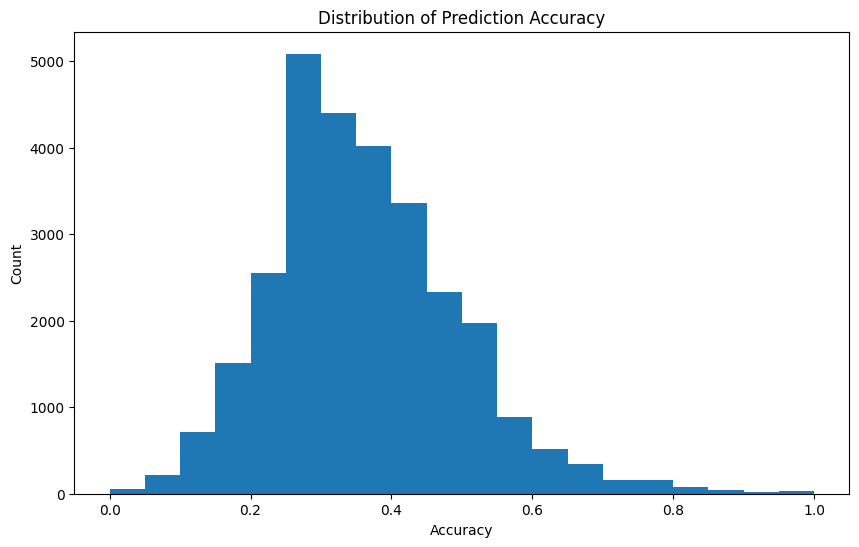


Top 5 employees by prediction accuracy:
employeeId
wsj5byx0kbfc7wm_40     1.000000
wioc0idpnmtifev_101    0.756157
wioc0idpnmtifev_9      0.752604
wsj5byx0kbfc7wm_91     0.708333
wioc0idpnmtifev_64     0.704167
Name: accuracy, dtype: float64

Bottom 5 employees by prediction accuracy:
employeeId
wsj5byx0kbfc7wm_104    0.196623
wsj5byx0kbfc7wm_27     0.173703
wsj5byx0kbfc7wm_24     0.164135
wsj5byx0kbfc7wm_101    0.144281
wioc0idpnmtifev_22     0.124402
Name: accuracy, dtype: float64


In [27]:
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random

def predict_sequences(model, sequences, app_to_idx, device):
    """Run predictions on sequences."""
    model.eval()
    predictions = []
    
    # Create dataset for inference
    inference_dataset = AppSequenceDataset(sequences, app_to_idx)
    inference_loader = DataLoader(inference_dataset, batch_size=64, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc='Predicting'):
            # Move batch to device
            app_ids = batch['app_ids'].to(device)
            # durations = batch['durations'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Get predictions
            outputs = model(app_ids, attention_mask)
            pred_logits = outputs.argmax(dim=-1)
            
            # Store predictions
            predictions.extend(pred_logits.cpu().numpy())
    
    return predictions

# Run predictions
print("Running predictions on inference sequences...")
predictions = predict_sequences(model, inference_sequences, app_to_idx, device)

# Create reverse mapping for analysis
idx_to_app = {v: k for k, v in app_to_idx.items()}

# Analyze predictions
def analyze_predictions(predictions, sequences, idx_to_app):
    """Analyze prediction results."""
    results = []
    
    for pred, seq in zip(predictions, sequences):
        # Convert prediction indices to app names
        pred_apps = [idx_to_app[idx] for idx in pred if idx < len(idx_to_app)]
        actual_apps = seq['apps']
        
        # Calculate metrics
        correct = sum(p == a for p, a in zip(pred_apps, actual_apps))
        total = len(actual_apps)
        accuracy = correct / total if total > 0 else 0
        
        results.append({
            'employeeId': seq['employeeId'],
            'accuracy': accuracy,
            'sequence_length': total,
            'correct_predictions': correct
        })
    
    return pd.DataFrame(results)

# Analyze results
results_df = analyze_predictions(predictions, inference_sequences, idx_to_app)

# Print summary statistics
print("\nPrediction Results:")
print(f"Average accuracy: {results_df['accuracy'].mean():.3f}")
print(f"Median accuracy: {results_df['accuracy'].median():.3f}")
print("\nAccuracy distribution:")
print(results_df['accuracy'].describe())

# Visualize results
plt.figure(figsize=(10, 6))
plt.hist(results_df['accuracy'], bins=20)
plt.title('Distribution of Prediction Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.show()

# Analyze per-employee performance
employee_performance = results_df.groupby('employeeId')['accuracy'].mean().sort_values(ascending=False)
print("\nTop 5 employees by prediction accuracy:")
print(employee_performance.head())
print("\nBottom 5 employees by prediction accuracy:")
print(employee_performance.tail())

In [48]:
def visualize_attention(model, sequence, app_to_idx):
    """Visualize attention patterns for a sequence."""
    model.eval()
    
    # Convert sequence to indices
    app_ids = [app_to_idx.get(app, app_to_idx['<UNK>']) for app in sequence['apps']]
    sequence_length = len(app_ids)
    attention_mask = [1] * sequence_length
    
    # Convert to tensors
    app_ids = torch.tensor(app_ids).unsqueeze(0).to(device)
    attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)
    
    # Get predictions and attention weights
    with torch.no_grad():
        _, attention_weights = model.model(app_ids, attention_mask, output_attentions=True)
        
        # Debug print
        print(f"Number of attention layers: {len(attention_weights)}")
        if attention_weights:
            print(f"Shape of first layer attention: {attention_weights[0].shape}")
    
    # Format attention weights for BertViz
    formatted_weights = []
    for layer_attn in attention_weights:
        # Add batch dimension back if needed
        if layer_attn.dim() == 3:
            layer_attn = layer_attn.unsqueeze(0)
        # Ensure shape is [1, num_heads, seq_len, seq_len]
        formatted_weights.append(layer_attn)
    
    # Stack layers along a new dimension
    stacked_weights = torch.stack(formatted_weights)
    
    # Truncate sequence if needed
    tokens = sequence['apps'][:sequence_length]
    
    # Debug prints
    print(f"\nFormatted attention weights shape: {stacked_weights.shape}")
    print(f"Number of tokens: {len(tokens)}")
    
    return tokens, stacked_weights

# Try visualization


# Create a custom visualization function that works with our attention format
def plot_attention_heads(attention_weights, tokens):
    """Plot attention weights for each layer and head."""
    num_layers, batch_size, num_heads, seq_len, _ = attention_weights.shape
    
    # Create a figure with subplots for each layer and head
    fig, axes = plt.subplots(num_layers, num_heads, 
                            figsize=(20, 5*num_layers),
                            squeeze=False)
    
    # Plot each attention head
    for layer in range(num_layers):
        for head in range(num_heads):
            ax = axes[layer, head]
            
            # Get attention weights for this head
            attn = attention_weights[layer, 0, head].cpu().numpy()
            
            # Create heatmap
            im = ax.imshow(attn, cmap='viridis')
            
            # Add colorbar
            plt.colorbar(im, ax=ax)
            
            # Set title
            ax.set_title(f'Layer {layer+1}, Head {head+1}')
            
            # Set labels
            if head == 0:
                ax.set_ylabel('Query tokens')
            if layer == num_layers-1:
                ax.set_xlabel('Key tokens')
            
            # Add token labels (show every nth token to avoid overcrowding)
            n = max(1, len(tokens) // 10)
            ax.set_xticks(range(0, len(tokens), n))
            ax.set_yticks(range(0, len(tokens), n))
            ax.set_xticklabels(tokens[::n], rotation=45, ha='right')
            ax.set_yticklabels(tokens[::n])
    
    plt.tight_layout()
    return fig

In [74]:
sequence = inference_sequences[5]  # Get a sample sequence
tokens, attention_weights = visualize_attention(model, sequence, app_to_idx)

Number of attention layers: 3
Shape of first layer attention: torch.Size([1, 4, 64, 64])

Formatted attention weights shape: torch.Size([3, 1, 4, 64, 64])
Number of tokens: 64


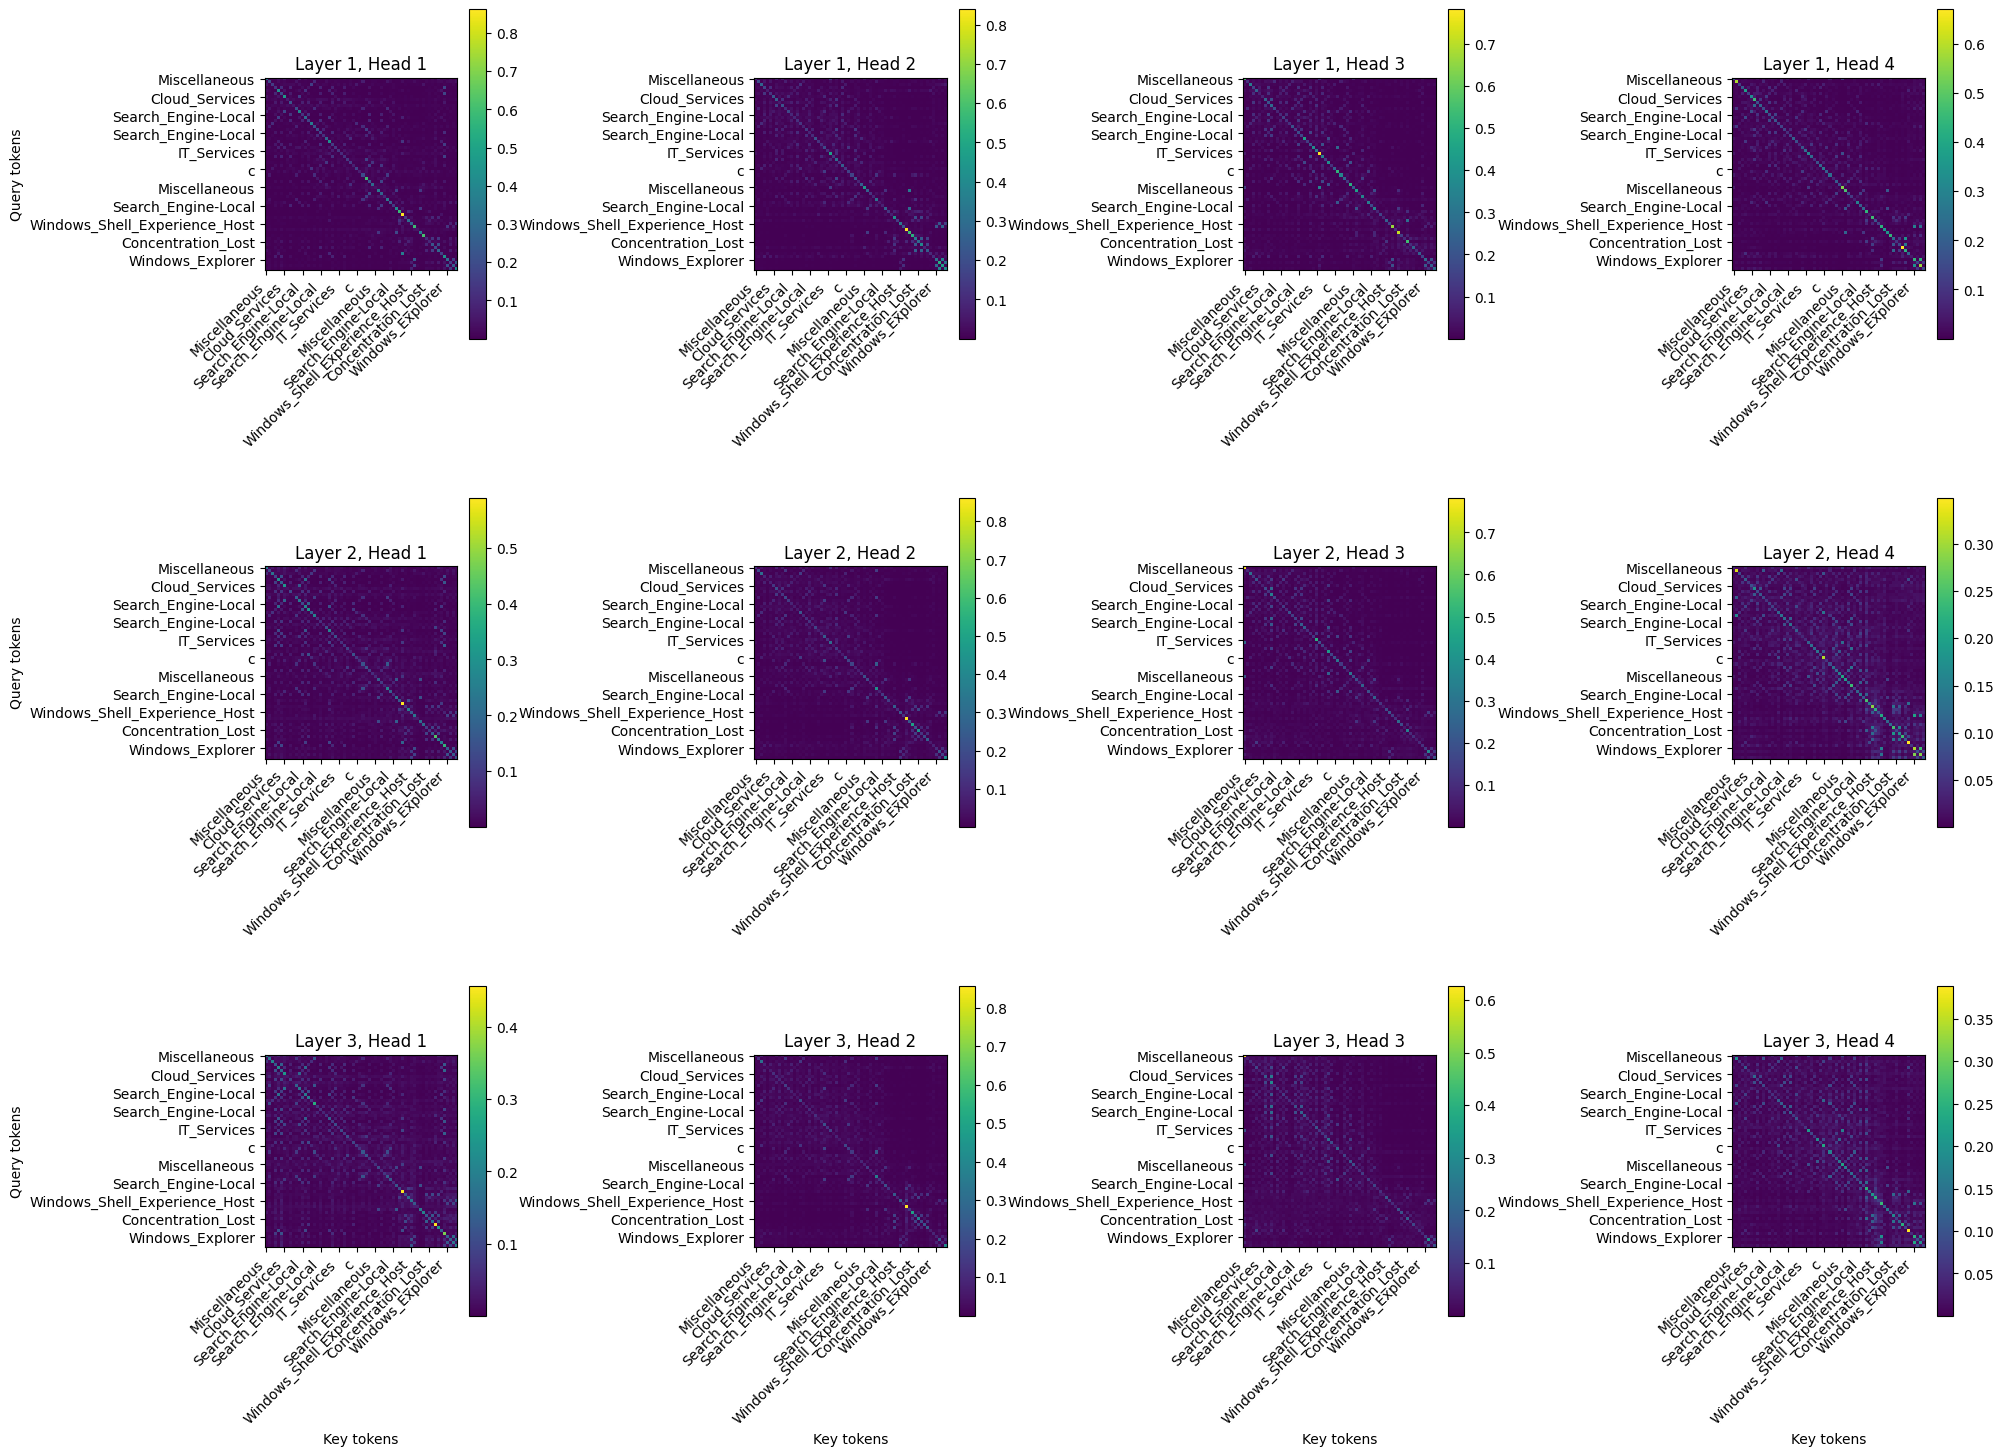

In [75]:
fig = plot_attention_heads(attention_weights, tokens)
plt.show()

In [64]:
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    sequence = inference_sequences[5] 
    tokens, attention_weights = visualize_attention(model, sequence, app_to_idx)
    # Convert attention weights to numpy
    attention_weights_np = attention_weights.cpu().numpy()
    num_layers, batch_size, num_heads, seq_len, _ = attention_weights_np.shape
    
    # Create subplots
    fig = make_subplots(
        rows=num_layers, 
        cols=num_heads,
        subplot_titles=[f'Layer {l+1}, Head {h+1}' for l in range(num_layers) for h in range(num_heads)]
    )
    
    # Add heatmaps for each layer and head
    for layer in range(num_layers):
        for head in range(num_heads):
            attn = attention_weights_np[layer, 0, head]
            
            fig.add_trace(
                go.Heatmap(
                    z=attn,
                    colorscale='Viridis',
                    showscale=True if head == num_heads-1 else False
                ),
                row=layer+1, 
                col=head+1
            )
    
    # Update layout
    fig.update_layout(
        height=300 * num_layers,
        width=250 * num_heads,
        title_text="Attention Patterns Across Layers and Heads",
        showlegend=False
    )
    
    # Save the plot
    output_dir = 'visualizations'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'attention_viz_{random.randint(0, 10000)}.html')
    
    fig.write_html(output_file)
    print(f"\nVisualization saved to: {output_file}")
    
except Exception as e:
    print(f"Error: {str(e)}")
    print("Full error:")
    import traceback
    traceback.print_exc()


Visualization saved to: visualizations\attention_viz_2192.html


In [77]:
try:
    from bertviz import head_view
    from IPython.display import HTML
    import random
    import os
    sequence = inference_sequences[150] 
    tokens, attention_weights = visualize_attention(model, sequence, app_to_idx)
    # Format attention weights for BertViz
    formatted_layers = attention_weights  # Keep as tensor
    
    # Generate HTML content as string
    html_content = head_view(formatted_layers, tokens, html_action="return")
    html_str = str(html_content)  # Convert HTML object to string
    
    # Save to file
    output_dir = 'visualizations'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'attention_viz_{random.randint(0, 10000)}.html')
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_str)  # Write the string version
    
    print(f"\nVisualization saved to: {output_file}")
    
    # Display in notebook
    display(html_content)  # Use display instead of returning HTML

except Exception as e:
    print(f"Error: {str(e)}")
    print("Full error:")
    import traceback
    traceback.print_exc()

Number of attention layers: 3
Shape of first layer attention: torch.Size([1, 4, 64, 64])

Formatted attention weights shape: torch.Size([3, 1, 4, 64, 64])
Number of tokens: 64

Visualization saved to: visualizations\attention_viz_3864.html


In [11]:
def predict_single_sequence(model, sequence, app_to_idx, device, top_k=3):
    """Run prediction on a single sequence and show top-k predictions for each position."""
    model.eval()
    
    # Prepare input
    dataset = AppSequenceDataset([sequence], app_to_idx)
    batch = dataset[0]
    
    # Move to device
    app_ids = batch['app_ids'].unsqueeze(0).to(device)
    attention_mask = batch['attention_mask'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(app_ids, attention_mask)
        
        # Get probabilities
        probs = torch.softmax(outputs.squeeze(), dim=-1)
        
        # Get top-k predictions for each position
        top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)
        
        # Convert to numpy for easier handling
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()
    
    # Create reverse mapping
    idx_to_app = {v: k for k, v in app_to_idx.items()}
    
    # Format results
    results = []
    actual_apps = sequence['apps']
    
    for pos in range(len(actual_apps)):
        predictions = [
            (idx_to_app[idx], prob) 
            for idx, prob in zip(top_indices[pos], top_probs[pos])
            if idx < len(idx_to_app)  # Filter out special tokens
        ]
        
        results.append({
            'position': pos,
            'actual': actual_apps[pos],
            'predictions': predictions
        })
    
    return results

# Let's analyze a few example sequences
n_examples = 3
example_sequences = inference_sequences[:n_examples]

for i, sequence in enumerate(example_sequences):
    print(f"\nAnalyzing Sequence {i+1}")
    print("=" * 50)
    
    results = predict_single_sequence(model, sequence, app_to_idx, device)
    
    # Print sequence analysis
    for r in results:
        print(f"\nPosition {r['position']}:")
        print(f"Actual: {r['actual']}")
        print("Top predictions:")
        for app, prob in r['predictions']:
            print(f"  - {app}: {prob:.3f}")


Analyzing Sequence 1

Position 0:
Actual: Windows_Explorer
Top predictions:
  - Microsoft_Teams: 0.338
  - Concentration_Lost: 0.183
  - Windows_Shell_Experience_Host: 0.168

Position 1:
Actual: Microsoft_Outlook
Top predictions:
  - Microsoft_Outlook: 0.461
  - Microsoft_Teams: 0.365
  - Pause: 0.032

Position 2:
Actual: Windows_Explorer
Top predictions:
  - Concentration_Lost: 0.330
  - Windows_Shell_Experience_Host: 0.193
  - Microsoft_Teams: 0.131

Position 3:
Actual: Microsoft_Teams
Top predictions:
  - Microsoft_Teams: 0.490
  - login.microsoftonline.com: 0.264
  - Mail-Local: 0.027

Position 4:
Actual: Search_Engine-Local
Top predictions:
  - Video_Conferencing: 0.175
  - Video_Conferencing-Local: 0.149
  - Concentration_Lost: 0.132

Position 5:
Actual: login.microsoftonline.com
Top predictions:
  - login.microsoftonline.com: 0.285
  - Microsoft_Teams: 0.201
  - Microsoft_Outlook: 0.171

Position 6:
Actual: Search_Engine-Local
Top predictions:
  - Concentration_Lost: 0.290
  - 

In [43]:
fig.show()

C:\Users\Nemanja\AppData\Local\Temp\ipykernel_5352\89474557.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


# Extract embeddings

In [37]:
# Extract app embeddings from the trained model
def extract_app_embeddings(model, app_to_idx, device):
    """Extract embeddings for all apps in the vocabulary."""
    model.eval()
    
    # Create a tensor with all app indices
    app_indices = torch.tensor(list(app_to_idx.values()), device=device)
    
    with torch.no_grad():
        # Get embeddings directly from embedding layer
        embeddings = model.app_embeddings(app_indices)
        
        # Move to CPU and convert to numpy
        embeddings = embeddings.cpu().numpy()
    
    # Create dictionary mapping apps to their embeddings
    app_embeddings = {
        app: embeddings[i] 
        for app, i in app_to_idx.items()
        if app not in ['<PAD>', '<UNK>']  # Skip special tokens
    }
    
    return app_embeddings

# Extract embeddings
app_embeddings = extract_app_embeddings(model, app_to_idx, device)

# Convert to DataFrame for easier analysis
embeddings_df = pd.DataFrame.from_dict(app_embeddings, orient='index')

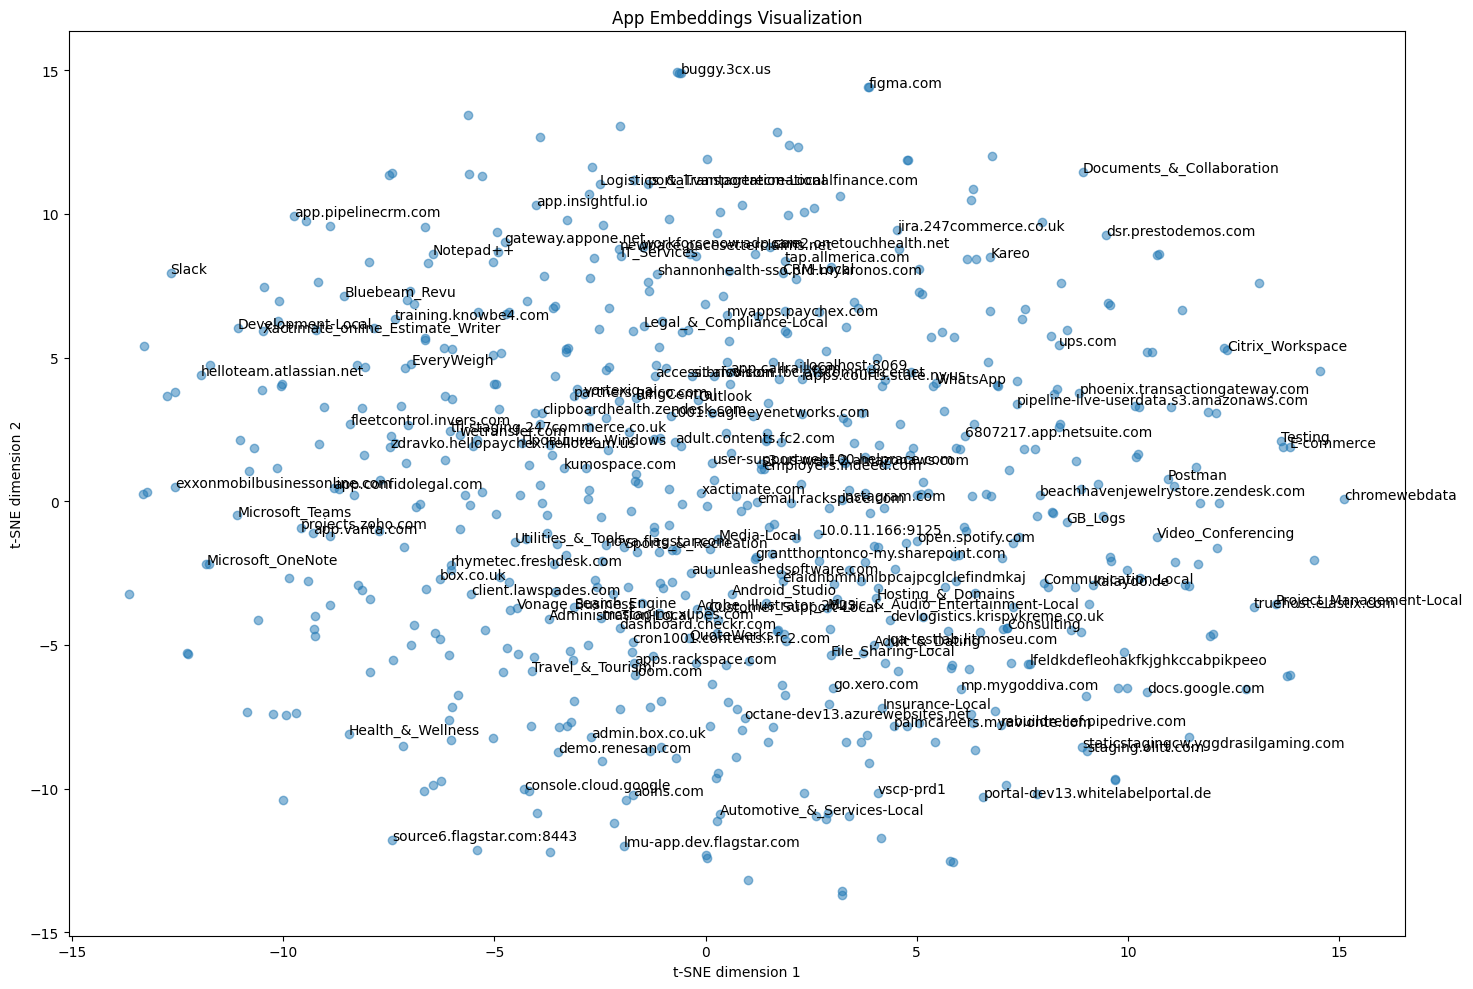


Number of apps with embeddings: 632
Embedding dimension: 64


In [38]:
embeddings_df# Reduce dimensionality for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# First reduce to 50 dimensions with PCA
pca = PCA(n_components=min(50, len(embeddings_df)))
embeddings_pca = pca.fit_transform(embeddings_df)

# Then reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Create visualization DataFrame
viz_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'], index=embeddings_df.index)

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(viz_df['x'], viz_df['y'], alpha=0.5)

# Add labels for some points (you might want to limit this to avoid overcrowding)
for idx, row in viz_df.iloc[::5].iterrows():  # Label every 5th point
    plt.annotate(idx, (row['x'], row['y']))

plt.title('App Embeddings Visualization')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.show()

# Print some statistics about the embeddings
print(f"\nNumber of apps with embeddings: {len(app_embeddings)}")
print(f"Embedding dimension: {embeddings_df.shape[1]}")



In [39]:
# Optional: Find similar apps using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_apps(app_name, embeddings_df, n=5):
    """Find n most similar apps to the given app based on embedding similarity."""
    if app_name not in embeddings_df.index:
        return []
    
    # Calculate cosine similarity
    similarities = cosine_similarity(
        embeddings_df.loc[app_name].values.reshape(1, -1),
        embeddings_df.values
    )[0]
    
    # Get indices of most similar apps
    most_similar = pd.Series(similarities, index=embeddings_df.index)\
        .sort_values(ascending=False)[1:n+1]  # Skip first (self)
    
    return most_similar

In [40]:
# Example: Find similar apps for a few examples
example_apps = ['Snagit', 'github.com', 'gitlab.fc2.com']  # Replace with actual apps in your dataset
for app in example_apps:
    if app in embeddings_df.index:
        print(f"\nApps similar to {app}:")
        similar_apps = find_similar_apps(app, embeddings_df)
        for similar_app, similarity in similar_apps.items():
            print(f"  - {similar_app}: {similarity:.3f}")


Apps similar to Snagit:
  - fedex.com: 0.374
  - localhost:8069: 0.370
  - businessonline-boi.com: 0.359
  - kumospace.com: 0.333
  - Paint: 0.325

Apps similar to github.com:
  - Health_&_Wellness-Local: 0.339
  - Adobe_Acrobat_Reader: 0.333
  - IT_Services: 0.321
  - chrome://newtab/: 0.305
  - admin.box.co.uk: 0.303

Apps similar to gitlab.fc2.com:
  - cron1001.contents.i.fc2.com: 0.382
  - apps.rackspace.com: 0.368
  - chrome://newtab/: 0.356
  - shopify-staging.bigdxpro.com: 0.345
  - Development-Local: 0.328


In [43]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,cluster
10.0.11.166:9125,0.004258,-0.532749,2.599877,0.458689,-1.067049,-0.996625,-0.229606,-1.244702,-0.137633,-0.078723,...,1.358217,-0.226026,-1.522789,0.723157,0.204177,-0.012799,1.094092,0.525360,-1.415506,3
10.1.52.141:8124,1.053942,0.382068,1.007349,0.472141,0.856217,0.945621,-0.643211,-1.376202,0.762523,-0.471287,...,-0.163311,-0.689626,-0.170979,0.475315,0.045049,0.254526,0.119112,-0.946172,-0.439092,3
10.2.2.18,-0.497314,-1.269500,0.373027,0.505372,0.281695,0.139899,-0.088666,-1.947264,1.473649,0.225129,...,0.050761,-0.198983,0.377130,1.164468,0.185942,1.435670,-0.066790,-0.972795,-0.376276,3
365online.com,-0.866841,-0.934161,-0.368434,-0.015966,1.092410,0.283961,0.158620,0.980897,0.009619,-1.143962,...,-0.879877,0.901460,0.962048,-0.270547,0.527974,-0.281691,-1.012674,-0.036263,0.081923,1
4dayjobs.de,1.229383,-1.374235,0.003328,1.304873,-0.802636,0.773421,-0.078264,-0.661607,0.315794,0.629914,...,-0.411126,-1.044157,-0.140848,-0.216533,0.701100,0.535221,-1.509207,0.047061,0.043851,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinfandel.centrastage.net,0.237094,-0.231419,0.471820,-0.443814,-2.176877,1.434099,-0.727126,0.786214,0.943220,0.000467,...,1.143818,0.085358,-1.187329,-0.492394,0.963912,0.704136,-0.878463,0.172940,0.111727,4
zinfandel.rmm.datto.com,-0.539295,1.088092,-0.252163,0.340581,1.003055,-0.200825,0.702202,0.392789,0.652685,1.972360,...,0.406505,1.220354,-1.039635,1.022919,0.483381,-0.720903,0.179731,-0.910563,0.922427,0
Проводник,0.273098,0.489983,0.431667,-0.414550,0.396709,-1.046934,-0.554838,-0.350716,-0.503817,-0.796073,...,0.049339,-0.370496,-0.102375,3.640990,0.022023,0.646921,0.128767,0.384479,-0.492706,0
Провідник_Windows,1.046615,0.581591,-1.152687,0.890545,-1.418524,0.244538,-0.219951,0.893883,0.037262,-0.004052,...,0.110913,-1.180264,-0.012197,-0.433582,-1.947287,-0.530669,0.734337,1.569759,-1.539934,0


In [44]:
# Perform clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the embeddings
scaler = StandardScaler()
if 'cluster' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['cluster'])
scaled_embeddings = scaler.fit_transform(embeddings_df)

# Try different numbers of clusters
n_clusters = 30  # Adjust this number based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_embeddings)

# Add cluster labels to DataFrame
embeddings_df['cluster'] = clusters

# Analyze clusters
for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    apps_in_cluster = embeddings_df[embeddings_df['cluster'] == cluster_id].index.tolist()
    print(f"Number of apps: {len(apps_in_cluster)}")
    print("Sample apps:")
    print(apps_in_cluster[:10]) 


Cluster 0:
Number of apps: 4
Sample apps:
['Finance', 'admin.dev.1939api.com', 'airbnb.com', 'portal.azure.com']

Cluster 1:
Number of apps: 70
Sample apps:
['10.1.52.141:8124', 'Adobe_Acrobat', 'Adobe_Photoshop_2024', 'Adult_&_Dating', 'Bluebeam_Revu', 'Cybersecurity', 'Documents_&_Storage', 'DraftworX', 'Engineering', 'Hospitality']

Cluster 2:
Number of apps: 4
Sample apps:
['app.vanta.com', 'dashboard-r4.tagalys.com', 'login.agillink.com', 'source6.flagstar.com:8443']

Cluster 3:
Number of apps: 12
Sample apps:
['Cloud_Services-Local', 'Concentration_Lost', 'Finance-Local', 'Job_Board', 'Other_Entertainment-Local', 'fleetcontrol.invers.com', 'lauprint.com', 'lfeldkdefleohakfkjghkccabpikpeeo', 'myfleetcenter.com', 'qatestlab.testrail.com']

Cluster 4:
Number of apps: 28
Sample apps:
['Accessibility-Local', 'Adobe_Photoshop_2021', 'Automotive_&_Services', 'Automotive_&_Services-Local', 'Family_&_Parenting', 'Gaming', 'Music_&_Audio_Entertainment', 'app.drata.com', 'app.justcall.io',

In [ ]:
apps_to_explore = exploded_df['app'].value_counts().index[:20]

for app in apps_to_explore:
    print(f"\nApps similar to {app}:")
    similar_apps = find_similar_apps(app, embeddings_df)
    for similar_app, similarity in similar_apps.items():
        print(f"  - {similar_app}: {similarity:.3f}")


# Include time

In [71]:
class ShallowTransformer_with_time(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, seq_length=64):
        super().__init__()
        
        # App embeddings
        self.app_embeddings = nn.Embedding(vocab_size, d_model)
        
        # Time feature projections
        self.time_projection = nn.Linear(2, d_model)  # For duration and time_since_start
        
        # Positional embeddings
        self.pos_embeddings = nn.Parameter(torch.randn(1, seq_length, d_model))
        
        # Single transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Prediction heads
        self.app_predictor = nn.Linear(d_model, vocab_size)
        self.duration_predictor = nn.Linear(d_model, 1)  # Predict duration
        
    def forward(self, app_ids, time_features, attention_mask):
        # Get app embeddings
        app_emb = self.app_embeddings(app_ids)
        
        # Project time features
        time_emb = self.time_projection(time_features)
        
        # Combine embeddings
        x = app_emb + time_emb + self.pos_embeddings[:, :app_emb.size(1), :]
        
        # Create attention mask for transformer
        attention_mask = attention_mask == 0
        
        # Pass through transformer
        x = self.transformer(x, src_key_padding_mask=attention_mask)
        
        # Return predictions
        return {
            'app': self.app_predictor(x),
            'duration': self.duration_predictor(x).squeeze(-1)
        }

class AppSequenceDataset_with_time(torch.utils.data.Dataset):
    def __init__(self, sequences, app_to_idx, sequence_length=64, mask_prob=0.15):
        self.sequences = sequences
        self.app_to_idx = app_to_idx
        self.sequence_length = sequence_length
        self.mask_prob = mask_prob
        self.mask_token = len(app_to_idx)  # Add MASK token at end of vocabulary
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        # Get sequence data
        apps = seq['apps'][:self.sequence_length]
        durations = seq['durations'][:self.sequence_length]
        times = seq['minutes_since_workday_start'][:self.sequence_length]
        
        # Convert apps to indices
        app_ids = [self.app_to_idx.get(app, self.app_to_idx['<UNK>']) 
                  for app in apps]
        
        # Create masked version for input
        masked_app_ids = app_ids.copy()
        app_labels = [-100] * len(app_ids)
        duration_labels = durations.copy()
        
        # Randomly mask tokens
        for i in range(len(app_ids)):
            if random.random() < self.mask_prob:
                app_labels[i] = app_ids[i]  # Save original app as label
                masked_app_ids[i] = self.mask_token  # Replace with MASK token
        
        # Pad sequences if needed
        if len(app_ids) < self.sequence_length:
            padding_length = self.sequence_length - len(app_ids)
            masked_app_ids.extend([self.app_to_idx['<PAD>']] * padding_length)
            app_labels.extend([-100] * padding_length)
            durations.extend([0] * padding_length)
            times.extend([0] * padding_length)
            duration_labels.extend([0] * padding_length)
        
        # Stack time features
        time_features = torch.tensor([[d, t] for d, t in zip(durations, times)], dtype=torch.float)
        
        return {
            'app_ids': torch.tensor(masked_app_ids),
            'time_features': time_features,
            'attention_mask': torch.tensor([1] * len(apps) + [0] * (self.sequence_length - len(apps))),
            'app_labels': torch.tensor(app_labels),
            'duration_labels': torch.tensor(duration_labels)
        }

In [72]:
def compute_loss_with_time(outputs, batch):
    # App prediction loss
    app_loss = F.cross_entropy(
        outputs['app'].view(-1, outputs['app'].size(-1)),
        batch['app_labels'].view(-1),
        ignore_index=-100
    )
    
    # Duration prediction loss (only for non-masked positions)
    mask = batch['attention_mask'] == 1
    duration_loss = F.mse_loss(
        outputs['duration'][mask],
        batch['duration_labels'][mask]
    )
    
    # Combine losses
    return app_loss + 0.1 * duration_loss  # You can adjust this weight